# Assignment 3

Mathia Quimpo, Matthew Chin, Wanqiu Zhang

## Exploration and Preprocessing

In [56]:
import pandas as pd
import numpy as np
import re
import os
import requests
import string
import nltk
import time
import matplotlib.pyplot as plt
import pyLDAvis
import seaborn as sns
import pyLDAvis.gensim_models as gensimvis
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, CoherenceModel
from sklearn.decomposition import LatentDirichletAllocation

In [7]:
# Load dataset
file_path = os.path.expanduser("~/Desktop/School/6200/Project/DisneylandReviews.csv")
df = pd.read_csv(file_path, encoding="ISO-8859-1")

print(df.head())

   Review_ID  Rating Year_Month     Reviewer_Location  \
0  670772142       4     2019-4             Australia   
1  670682799       4     2019-5           Philippines   
2  670623270       4     2019-4  United Arab Emirates   
3  670607911       4     2019-4             Australia   
4  670607296       4     2019-4        United Kingdom   

                                         Review_Text               Branch  
0  If you've ever been to Disneyland anywhere you...  Disneyland_HongKong  
1  Its been a while since d last time we visit HK...  Disneyland_HongKong  
2  Thanks God it wasn   t too hot or too humid wh...  Disneyland_HongKong  
3  HK Disneyland is a great compact park. Unfortu...  Disneyland_HongKong  
4  the location is not in the city, took around 1...  Disneyland_HongKong  


In [8]:
# Display column names
print("Columns in the dataset:\n", df.columns)

Columns in the dataset:
 Index(['Review_ID', 'Rating', 'Year_Month', 'Reviewer_Location', 'Review_Text',
       'Branch'],
      dtype='object')


In [9]:
# Get general info
print(df.info())

# Descriptive statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42656 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42656 non-null  int64 
 1   Rating             42656 non-null  int64 
 2   Year_Month         42656 non-null  object
 3   Reviewer_Location  42656 non-null  object
 4   Review_Text        42656 non-null  object
 5   Branch             42656 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.0+ MB
None
          Review_ID        Rating
count  4.265600e+04  42656.000000
mean   3.188553e+08      4.217695
std    1.657092e+08      1.063371
min    1.398724e+06      1.000000
25%    1.743274e+08      4.000000
50%    2.907583e+08      5.000000
75%    4.489579e+08      5.000000
max    6.708014e+08      5.000000
Review_ID            0
Rating               0
Year_Month           0
Reviewer_Location    0
Review_Text          0
Branch               0
dtype: int64


In [10]:
# Display the entire review text
pd.set_option('display.max_colwidth', None)

In [15]:
# Identify the main text column
text_column = "Review_Text"

# Basic statistics on text length
df["text_length"] = df[text_column].astype(str).apply(len)

print("\nText Length Statistics:")
print(df["text_length"].describe())

# Spot-check a few reviews
print("\nSample Reviews:\n", df[text_column].sample(7, random_state=40))


Text Length Statistics:
count    42656.000000
mean       696.817540
std        831.396751
min         18.000000
25%        239.000000
50%        435.000000
75%        837.000000
max      20756.000000
Name: text_length, dtype: float64

Sample Reviews:
 4018                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         We spent 2 days with our girls, 9 and 6, and had a fantastic time. Ideal for kids of our age who could go on most rides. Sometimes height can be an issue at theme parks but not in Hong Kong!Sunday and Monday were good days to visit, with 

In [13]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [26]:
# Define text cleaning function
def clean_text(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    words = word_tokenize(text)  # Tokenize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lemmatization and stopword removal
    return " ".join(words)

In [27]:
# Apply cleaning function
df["cleaned_text"] = df[text_column].apply(clean_text)

In [28]:
# Spot-check cleaned reviews
print("\nSample Cleaned Reviews:\n", df["cleaned_text"].sample(5, random_state=42))


Sample Cleaned Reviews:
 31092                                                                                                                                                                                                    disneyland beautiful largeto see need stay least daysas lot people large quits worth good organized best holiday experience
28105    line ride long yes fast pass help little standing line hour get min ride ridiculous rd trip feel like keep getting worse longer there people le space ride go could day ive gone think ill sticking park arent busy im sure however youre young impressionable child love notice im past age stomach kind work reward ratio
1121                                                                                                                                                                                                          loved hong kong disneyland although much smaller anaheim one big queue happy atmosphere beautiful clean organised park

## CountVectorizer

In [32]:
# 1️⃣ Use CountVectorizer for Bag of Words model
count_vectorizer = CountVectorizer(max_features=10000, stop_words='english')

# Create the Bag of Words matrix
X_bow = count_vectorizer.fit_transform(df["cleaned_text"])

# Get feature names
feature_names = count_vectorizer.get_feature_names_out()

# Display shape of the BoW matrix
print(f"\nBag of Words Matrix Shape: {X_bow.shape}")

# Tokenized texts for LDA (split the cleaned text into words)
tokenized_texts = [text.split() for text in df["cleaned_text"]]
dictionary = Dictionary(tokenized_texts)  # Using preprocessed (tokenized) texts
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]


Bag of Words Matrix Shape: (42656, 10000)


## LDA

In [72]:
# Train LDA Model
def train_lda(corpus, dictionary, num_topics=7):
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                         random_state=42, passes=15, iterations=500, alpha='auto')
    return lda_model

lda_model = train_lda(corpus, dictionary, num_topics=7)

In [73]:
# Compute Coherence Score
def compute_coherence(lda_model, texts, dictionary):
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

coherence_score = compute_coherence(lda_model, tokenized_texts, dictionary)
print(f'Coherence Score: {coherence_score:.4f}')

Coherence Score: 0.4817


In [74]:
# Compute Perplexity Score
perplexity = lda_model.log_perplexity(corpus)
print(f'Perplexity Score: {np.exp(perplexity):.4f}')  # Convert log perplexity to perplexity

Perplexity Score: 0.0006


In [75]:
# Visualizing LDA Topics with pyLDAvis
pyLDAvis.enable_notebook()
lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_vis)

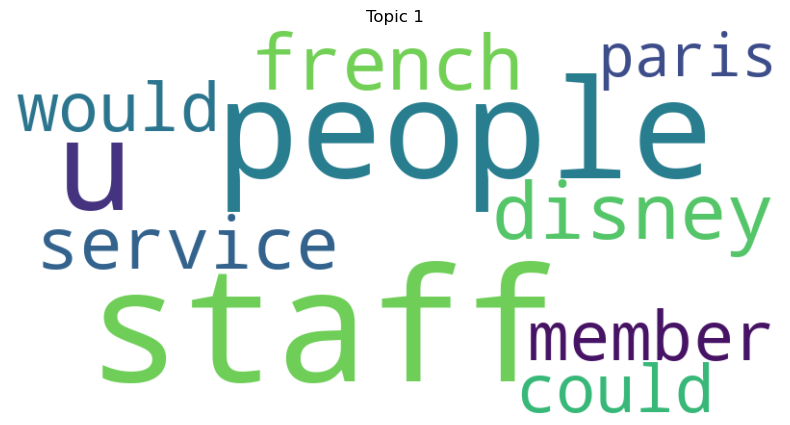

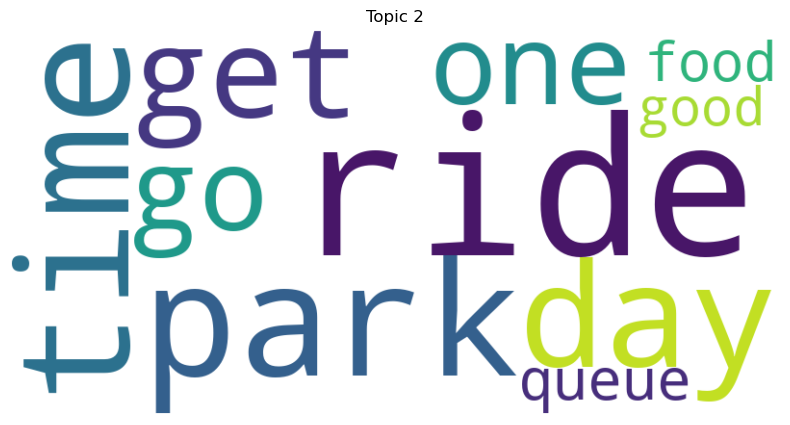

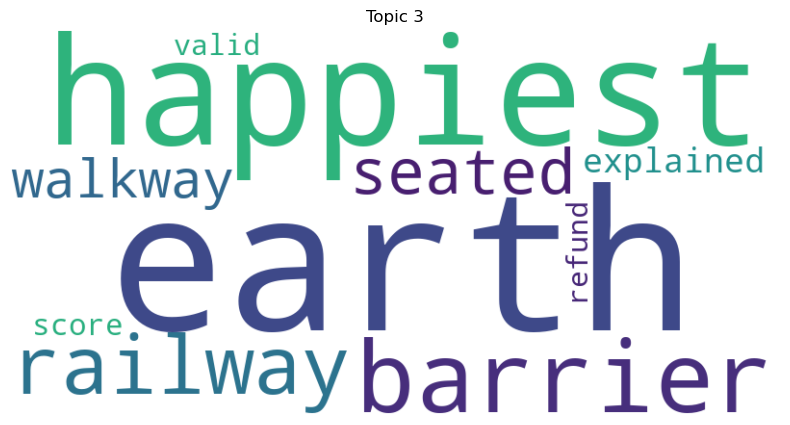

In [76]:
# Generate Word Clouds for Each Topic
lda_topic_words = {}

for topic in range(3):  # Number of topics
    words = dict(lda_model.show_topic(topic, 10))  # Extract top 10 words
    topic_to_print = topic + 1
    lda_topic_words[f"Topic {topic_to_print}"] = list(words.keys())  # Store words

    # Generate Word Cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {topic_to_print}")
    plt.show()

In [77]:
# Print the top words for each topic (for example, the top 10 words)
num_words = 10
topics = lda_model.print_topics(num_words=num_words)

for topic in topics:
    print(f"Topic {topic[0]}: {topic[1]}")


Topic 0: 0.027*"staff" + 0.021*"people" + 0.017*"u" + 0.011*"disney" + 0.010*"french" + 0.009*"service" + 0.008*"member" + 0.008*"would" + 0.008*"could" + 0.007*"paris"
Topic 1: 0.030*"ride" + 0.023*"park" + 0.022*"time" + 0.021*"day" + 0.016*"get" + 0.013*"go" + 0.013*"one" + 0.012*"queue" + 0.010*"food" + 0.010*"good"
Topic 2: 0.043*"earth" + 0.038*"happiest" + 0.012*"barrier" + 0.011*"railway" + 0.011*"seated" + 0.011*"walkway" + 0.011*"explained" + 0.008*"score" + 0.008*"valid" + 0.007*"refund"
Topic 3: 0.054*"disney" + 0.041*"disneyland" + 0.035*"park" + 0.020*"place" + 0.018*"great" + 0.017*"visit" + 0.017*"paris" + 0.013*"year" + 0.012*"experience" + 0.012*"fun"
Topic 4: 0.054*"mountain" + 0.034*"space" + 0.024*"thunder" + 0.024*"pirate" + 0.022*"coaster" + 0.019*"star" + 0.017*"buzz" + 0.015*"tour" + 0.013*"big" + 0.013*"caribbean"
Topic 5: 0.065*"hotel" + 0.021*"meal" + 0.016*"room" + 0.015*"breakfast" + 0.014*"restaurant" + 0.014*"stayed" + 0.014*"ticket" + 0.014*"train" + 0.

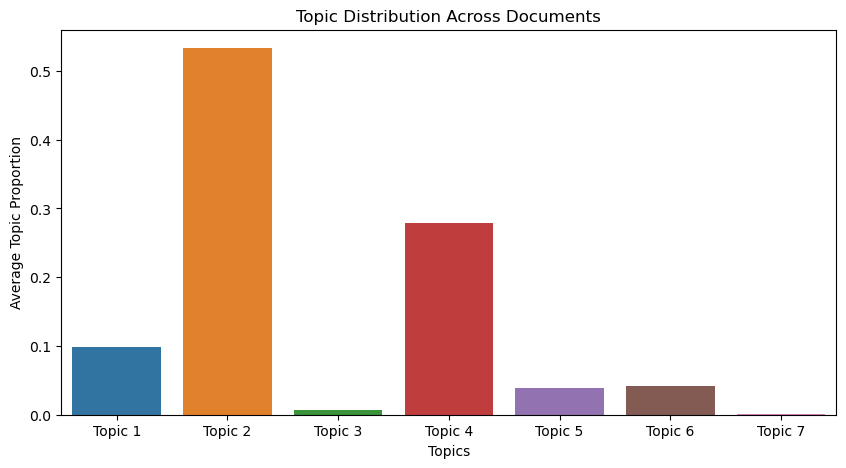

In [78]:
# Visualize Topic Distribution
def plot_topic_distributions(lda_model, corpus):
    topic_proportions = np.array([lda_model.get_document_topics(doc, minimum_probability=0) for doc in corpus])
    topic_proportions = np.array([[prob for _, prob in doc] for doc in topic_proportions])
    avg_topic_proportions = topic_proportions.mean(axis=0)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=[f'Topic {i+1}' for i in range(len(avg_topic_proportions))], y=avg_topic_proportions)
    plt.xlabel("Topics")
    plt.ylabel("Average Topic Proportion")
    plt.title("Topic Distribution Across Documents")
    plt.show()

plot_topic_distributions(lda_model, corpus)

In [80]:
# Print the 10 most common topics
lda_model.print_topics()

# Function to get topic distribution for each document
def get_topic_distribution(lda_model, corpus):
    topic_distributions = []
    for doc in corpus:
        topic_dist = lda_model.get_document_topics(doc, minimum_probability=0)
        topic_dist_dict = dict(topic_dist)
        for i in range(lda_model.num_topics):
            if i not in topic_dist_dict:
                topic_dist_dict[i] = 0
        topic_distributions.append(topic_dist_dict)

    # Create a DataFrame
    df_topic_distributions = pd.DataFrame(topic_distributions)
    df_topic_distributions = df_topic_distributions.reindex(sorted(df_topic_distributions.columns), axis=1)
    return df_topic_distributions

# Example usage (assuming lda_model and corpus are already defined):
topic_distribution_df = get_topic_distribution(lda_model, corpus)
topic_distribution_df

,0,1,2,3,4,5,6
0,0.044409,0.506113,0.003284,0.413922,0.015288,0.016282,0.000703
1,0.142876,0.245186,0.029035,0.373242,0.189181,0.020174,0.000306
2,0.076431,0.685445,0.001781,0.218156,0.008241,0.009565,0.000381
3,0.120812,0.519381,0.017106,0.273272,0.013541,0.055335,0.000554
4,0.066563,0.516434,0.005069,0.358557,0.019914,0.032377,0.001085
...,...,...,...,...,...,...,...
42651,0.032721,0.554791,0.001630,0.167583,0.006649,0.236277,0.000349
42652,0.024627,0.681490,0.001627,0.196251,0.006483,0.089173,0.000348
42653,0.031577,0.666914,0.002391,0.223772,0.025008,0.049826,0.000512
42654,0.084760,0.358445,0.015387,0.238805,0.036425,0.265726,0.000451
